In [1]:
import cv2
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from IPython.display import Image,display

In [2]:
Data_path ="/home/mady/Downloads/catsVSdogs/train/"
train_data_files = os.listdir(Data_path)
path = '/home/mady/Desktop/Deep-math-machine-learning.ai/Meetups_Notebooks/CNN_End2End/model_outputs/'

In [3]:
def get_one_hot_label(train_image):
    if "cat" in train_image:
        return [1,0]
    else:
        return [0,1]

In [4]:
def get_data():
    
    trainX,trainY = [],[]
    
    for train_image in train_data_files:
        
        trainX.append(image.img_to_array(image.load_img(Data_path+train_image, target_size=(64, 64)))/255)
        trainY.append(get_one_hot_label(train_image))
    
    return np.array(trainX),np.array(trainY)

In [5]:
trainX,trainY = get_data()

In [6]:
print(trainX.shape , trainY.shape)

(25000, 64, 64, 3) (25000, 2)


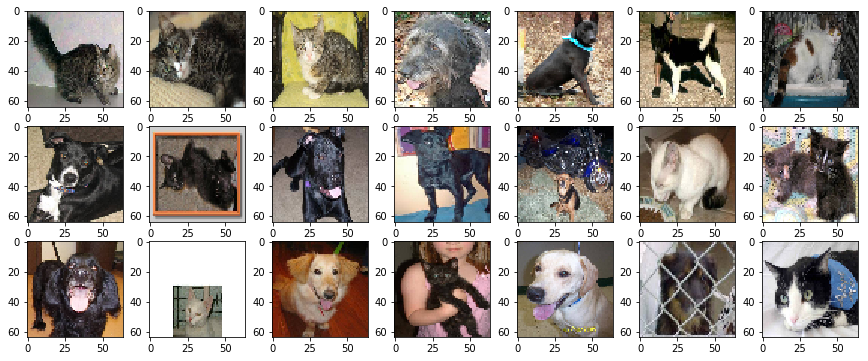

In [7]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(trainX[i])
plt.show()

In [8]:
def model(inputs):
    
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights',
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[16],
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(inputs, weights, strides=[1,1,1,1], padding='SAME')
        add_bias = tf.nn.bias_add(conv, biases)

        conv1 = tf.nn.relu(add_bias, name= scope.name)

        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        

    with tf.variable_scope("conv2") as scope:
        
        weights = tf.get_variable("weights",
                                 shape = [3,3,16,32],
                                 dtype = tf.float32,
                                 initializer = tf.truncated_normal_initializer(stddev=0.1,dtype = tf.float32))
        biases =  tf.get_variable("biases",
                                 shape = [32],
                                 dtype = tf.float32,
                                 initializer = tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(pool1,weights,strides=[1,1,1,1],padding = "SAME")
        add_bias = tf.nn.bias_add(conv,biases)

        conv2 = tf.nn.relu(add_bias,name = "conv2")

        pool2 = tf.nn.max_pool(conv2,ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')

    with tf.variable_scope('fc3') as scope:
        
        layer_shape = pool2.get_shape()
        num_features = layer_shape[1:4].num_elements()
        flatten_layer = tf.reshape(pool2, [-1, num_features])
    
        flatten_dim = flatten_layer.get_shape()[1]

        weights = tf.get_variable('weights',
                                  shape=[flatten_dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[128],
                                  dtype=tf.float32, 
                                  initializer=tf.constant_initializer(0.1))

        fc3 = tf.nn.relu(tf.matmul(flatten_layer, weights) + biases, name=scope.name)    

    with tf.variable_scope('fc4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc4 = tf.nn.relu(tf.matmul(fc3, weights) + biases, name='fc4')


    with tf.variable_scope('output') as scope:

        weights = tf.get_variable('weights5',
                                  shape=[128, 2],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases5', 
                                 shape=[2],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        logits = tf.add(tf.matmul(fc4, weights), biases, name='final_logits')


    return logits

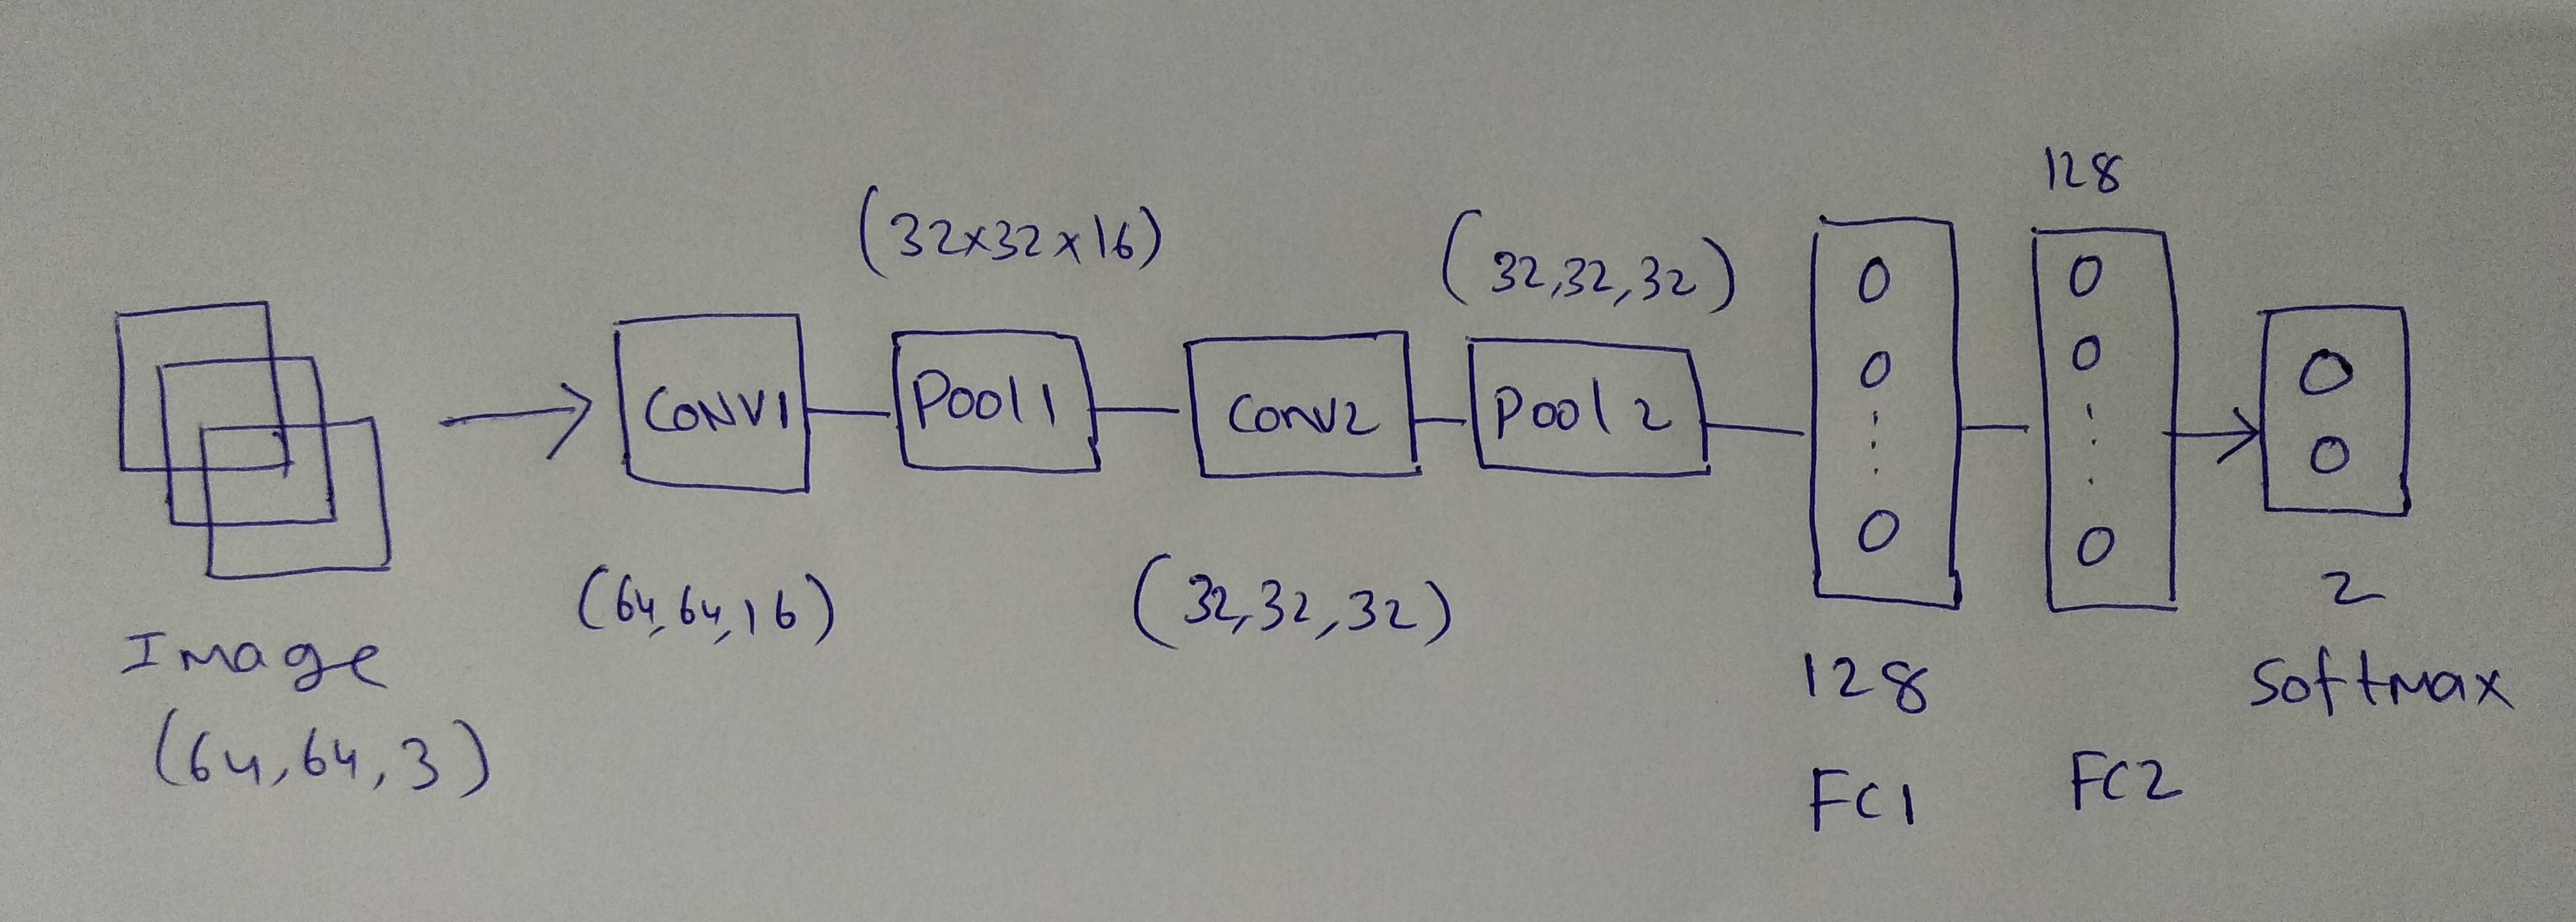

In [12]:
display(Image("images/model.jpg",width=450,height=450))

In [13]:
tf.reset_default_graph()
X = tf.placeholder("float", [None,64,64,3],name = "Input")
Y = tf.placeholder("float", [None,2])

logits = model(X)

total_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer=tf.train.GradientDescentOptimizer(0.05).minimize(total_cost)

In [14]:
predict_outputs_Y = tf.argmax(logits, 1,name = "Argmax",output_type=tf.int32) # at predict time, evaluate the argmax
predict_softmaxs_Y = tf.nn.softmax(logits, 1,name ="Softmax")

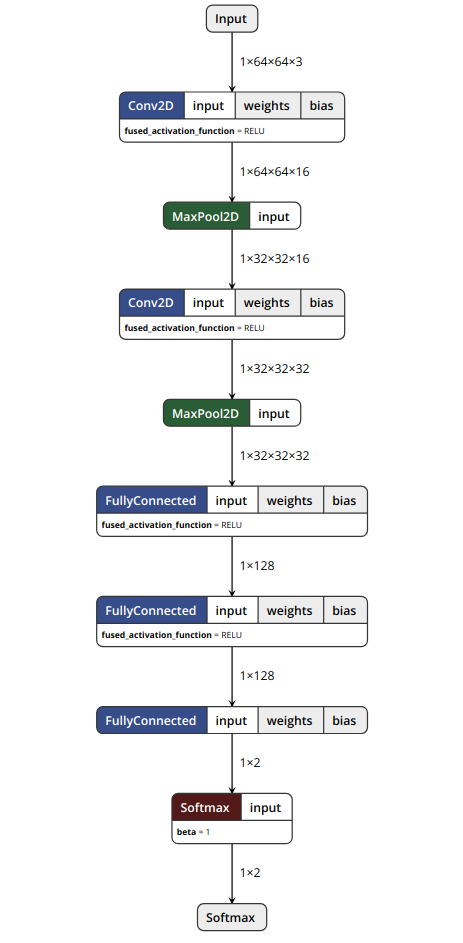

In [15]:
display(Image("images/vis_model.png",width=450,height=100))

In [16]:
def get_accuracy (inputs,labels,sess):
    return np.mean(np.argmax(labels, axis=1) == sess.run(predict_outputs_Y, feed_dict={X: inputs}))

In [22]:
def save_tf_model(sess,path,model_name):

    tf.train.write_graph(sess.graph_def, '.', path+model_name+'.pbtxt')
    print("model protobuf is stored successfully!")

    saver = tf.train.Saver()
    saver.save(sess, path+model_name)
    print("model checkpoint is saved successfully!")


def freeze_tf_model(path,model_name):

    input_graph_path = path+model_name+'.pbtxt'
    checkpoint_path = path+model_name
    input_saver_def_path = ""
    input_binary = False
    output_node_names = "Softmax"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = path+'frozen_'+model_name+'.pb'
    clear_devices = True

    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_frozen_graph_name, clear_devices, "")
    
    print("model is freezed successfully!")
    
def convert_to_tflite():
    converter = tf.contrib.lite.TocoConverter.from_frozen_graph(path+'frozen_catsVSdogs45.pb', ['Input'], ['Softmax']])
    tflite_model = converter.convert()
    open(path+"catsVSdogs45.tflite", "wb").write(tflite_model)
    print("Model is written as tflite")

In [18]:
epochs = 26
epoch_cost = []

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

print("Training started")
for epoch in range(epochs):
    total_batch_cost = 0
    
    for start, end in zip(range(0, len(trainX), 32), range(32, len(trainX)+1, 32)):
        feed_dict = {X : trainX[start:end] , Y : trainY[start:end]}
        _,batch_cost = sess.run([optimizer,total_cost],feed_dict=feed_dict) #main 
        total_batch_cost += batch_cost    
    print("Epoch cost is :",total_batch_cost)
    epoch_cost.append(total_batch_cost)
    
    if epoch % 15 == 0 and epoch is not 0:
        save_tf_model(sess,path,"catsVSdogs"+str(epoch))
        freeze_tf_model(path,"catsVSdogs"+str(epoch))
        #convert_to_tflite()

Training started
Epoch cost is : 541.5058250427246
Epoch cost is : 529.3181968331337
Epoch cost is : 453.28449177742004
Epoch cost is : 395.15225782990456
Epoch cost is : 351.11828653514385
Epoch cost is : 314.40140122175217
Epoch cost is : 277.18710152059793
Epoch cost is : 234.16103821992874
Epoch cost is : 199.3769160658121
Epoch cost is : 147.58934924565256
Epoch cost is : 104.02439562231302
Epoch cost is : 83.13519899453968
Epoch cost is : 65.14057861221954
Epoch cost is : 53.87516906647943
Epoch cost is : 42.43935958377551
Epoch cost is : 27.56255828635767
model protobuf is stored successfully!
model checkpoint is saved successfully!
INFO:tensorflow:Restoring parameters from /home/mady/Desktop/Deep-math-machine-learning.ai/Meetups_Notebooks/CNN_End2End/model_outputs/catsVSdogs15
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
model is freezed successfully!
Epoch cost is : 25.093678951525362
Epoch cost is : 21.101129890594166
Epoch cost is 

In [19]:
epoch_cost

[541.5058250427246,
 529.3181968331337,
 453.28449177742004,
 395.15225782990456,
 351.11828653514385,
 314.40140122175217,
 277.18710152059793,
 234.16103821992874,
 199.3769160658121,
 147.58934924565256,
 104.02439562231302,
 83.13519899453968,
 65.14057861221954,
 53.87516906647943,
 42.43935958377551,
 27.56255828635767,
 25.093678951525362,
 21.101129890594166,
 23.99572514371539,
 15.956553336975048,
 12.586106190428836,
 10.376349512975139,
 8.802263715253503,
 14.402054034519097,
 6.097352205242714,
 7.627736699849265,
 5.295613234773555,
 4.836197942480794,
 5.899311491714798,
 10.351353770092828,
 6.196233386950553,
 7.397878023688463,
 2.7801435745452636,
 0.6678490882848109,
 0.7676986176250011,
 0.7410788511263036,
 0.3578440718629281,
 0.06137779457424131,
 0.04388126800134273,
 0.037528612102335046,
 0.033153546375274345,
 0.02981627417278787,
 0.027141965758644915,
 0.02493862188899243,
 0.023083312716437376,
 0.021498677103750197]

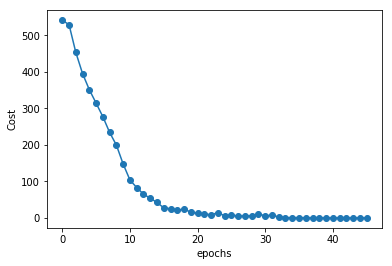

In [20]:
def visulize_cost(epoch_cost):
    indices = [i for i in range(len(epoch_cost))]
    plt.plot(indices,epoch_cost,marker="o")
    plt.xlabel("epochs")
    plt.ylabel("Cost")
    plt.show()
visulize_cost(epoch_cost)

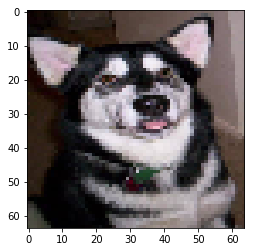

[array([[2.1269057e-17, 1.0000000e+00]], dtype=float32)]
0.00
1.00


In [21]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

graph = load_graph(path+'frozen_catsVSdogs45.pb')
# for op in graph.get_operations():
#     print(op.name)
    
x = graph.get_tensor_by_name('import/Input:0')
y = graph.get_tensor_by_name('import/Softmax:0')

image = trainX[819]
plt.imshow(image)
plt.show()
image = np.expand_dims(image,axis=0)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    output = sess.run([y],feed_dict={x:image})
    print(output)
    
    float_formatter = lambda x: "%.2f" % x
    
    for i in output[0][0]:
        print(float_formatter(i))
    
#     #Checking the accuracy of training

#     acc_list=[]
#     for start, end in zip(range(0, len(trainX), 32), range(32, len(trainX)+1, 32)):
#         feed_dict = {x : trainX[start:end]}
#         y_hat = sess.run(y,feed_dict=feed_dict)

#         acc = np.mean(np.argmax(trainY[start:end], axis=1) == np.argmax(y_hat,axis=1))
#         acc_list.append(acc)
#     print("Final accuracy is ",np.mean(acc_list))

In [23]:
convert_to_tflite()

Model is written as tflite


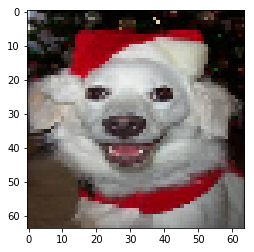

[[8.470218e-12 1.000000e+00]]


In [24]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(path+"catsVSdogs45.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
from tensorflow.keras.preprocessing import image
# input_data = trainX[0]
input_data = image.img_to_array(image.load_img("/home/mady/Downloads/catsVSdogs/train/dog.168.jpg", target_size=(64, 64)))/255

plt.imshow(input_data)
plt.show()

input_data = np.expand_dims(input_data,axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)